In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Đồ án biểu diễn (Dự báo giá chứng khoán)/dataset/VNM.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-12-01,20.879999,20.980000,20.750000,20.799999,20.696852,195600
1,2021-12-02,20.799999,20.850000,20.680000,20.719999,20.617249,296800
2,2021-12-03,20.500000,20.549999,20.280001,20.370001,20.268986,251000
3,2021-12-06,20.000000,20.049999,19.870001,20.010000,19.910770,502800
4,2021-12-07,20.379999,20.559999,20.320000,20.510000,20.408291,339700


In [ ]:
from collections import deque
import random

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate, name):
        with tf.compat.v1.variable_scope(name):
            self.X = tf.compat.v1.placeholder(tf.float32, (None, None, input_size))
            self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
            cell = tf.compat.v1.nn.rnn_cell.LSTMCell(layer_size, state_is_tuple = False)
            self.hidden_layer = tf.compat.v1.placeholder(tf.float32, (None, 2 * layer_size))
            self.rnn,self.last_state = tf.compat.v1.nn.dynamic_rnn(inputs=self.X,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
            tensor_action, tensor_validation = tf.split(self.rnn[:,-1],2,1)
            feed_action = tf.compat.v1.layers.dense(tensor_action, output_size)
            feed_validation = tf.compat.v1.layers.dense(tensor_validation, 1)
            self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(input_tensor=feed_action,axis=1,keepdims=True))
            self.cost = tf.reduce_sum(input_tensor=tf.square(self.Y - self.logits))
            self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)

class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.compat.v1.reset_default_graph()
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE,
                           'real_model')
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE,
                                   'negative_model')
        self.sess = tf.compat.v1.InteractiveSession()
        self.sess.run(tf.compat.v1.global_variables_initializer())
        self.trainable = tf.compat.v1.trainable_variables()

    def _assign(self, from_name, to_name):
        from_w = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=from_name)
        to_w = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=to_name)
        for i in range(len(from_w)):
            assign_op = to_w[i].assign(from_w[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, dead, rnn_state):
        self.MEMORIES.append((state, action, reward, new_state, dead, rnn_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        init_values = np.array([a[-1] for a in replay])
        Q = self.sess.run(self.model.logits, feed_dict={self.model.X:states,
                                                   self.model.hidden_layer:init_values})
        Q_new = self.sess.run(self.model.logits, feed_dict={self.model.X:new_states,
                                                       self.model.hidden_layer:init_values})
        Q_new_negative = self.sess.run(self.model_negative.logits,
                                  feed_dict={self.model_negative.X:new_states,
                                             self.model_negative.hidden_layer:init_values})
        replay_size = len(replay)
        X = np.empty((replay_size, 4, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        INIT_VAL = np.empty((replay_size, 2 * self.LAYER_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, dead_r, rnn_memory = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not dead_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
            INIT_VAL[i] = rnn_memory
        return X, Y, INIT_VAL

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        init_value = np.zeros((1, 2 * self.LAYER_SIZE))
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(self.trend) - 1, self.skip):
            action, last_state = self.sess.run([self.model.logits,self.model.last_state],
                                                feed_dict={self.model.X:[self.INITIAL_FEATURES],
                                                            self.model.hidden_layer:init_value})
            action, init_value = np.argmax(action[0]), last_state
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest


    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign('real_model', 'negative_model')

                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:
                    action, last_state = self.sess.run([self.model.logits,
                                                  self.model.last_state],
                                                  feed_dict={self.model.X:[self.INITIAL_FEATURES],
                                                             self.model.hidden_layer:init_value})
                    action, init_value = np.argmax(action[0]), last_state

                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)

                self._memorize(self.INITIAL_FEATURES, action, invest, new_state,
                               starting_money < initial_money, init_value[0])
                self.INITIAL_FEATURES = new_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y, INIT_VAL = self._construct_memories(replay)

                cost, _ = self.sess.run([self.model.cost, self.model.optimizer],
                                        feed_dict={self.model.X: X, self.model.Y:Y,
                                                  self.model.hidden_layer: INIT_VAL})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

<ipython-input-4-fa9db5e11f11>:9: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(layer_size, state_is_tuple = False)
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
<ipython-input-4-fa9db5e11f11>:15: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_action = tf.compat.v1.layers.dense(tensor_action, output_size)
<ipython-input-4-fa9db5e11f11>:16: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_validation = tf.compat.v1.layers.dense(tensor_validation, 1)


epoch: 10, total rewards: -32.080000.3, cost: 0.000053, total money: 9864.580000
epoch: 20, total rewards: -29.610003.3, cost: 0.000094, total money: 9970.389997
epoch: 30, total rewards: -26.600001.3, cost: 0.000143, total money: 9906.179999
epoch: 40, total rewards: -12.790004.3, cost: 0.000064, total money: 9908.699996
epoch: 50, total rewards: -17.350004.3, cost: 0.000042, total money: 9982.649996
epoch: 60, total rewards: -38.989998.3, cost: 0.000066, total money: 9961.010002
epoch: 70, total rewards: -23.799996.3, cost: 0.000132, total money: 9976.200004
epoch: 80, total rewards: -6.799993.3, cost: 0.000103, total money: 9959.110007
epoch: 90, total rewards: -9.420004.3, cost: 0.000010, total money: 9978.379996
epoch: 100, total rewards: -9.410006.3, cost: 0.000055, total money: 9990.589994
epoch: 110, total rewards: -9.770006.3, cost: 0.000018, total money: 9990.229994
epoch: 120, total rewards: -6.750001.3, cost: 0.000017, total money: 9981.049999
epoch: 130, total rewards: -20

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 39: buy 1 unit at price 19.370001, total balance 9980.629999
day 42, sell 1 unit at price 19.830000, investment 2.374801 %, total balance 10000.459999,
day 137: buy 1 unit at price 14.820000, total balance 9985.639999
day 138, sell 1 unit at price 14.540000, investment -1.889339 %, total balance 10000.179999,


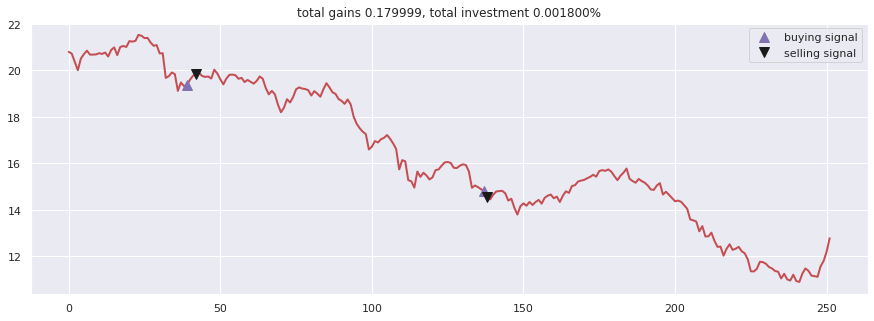

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()